just a little javascript blurb to enable sublime-like key-bindings - courtesy internets

In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

## Dot-calling and pileup figure

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
####################################################
# bunch of modules to load - expect redundancies
####################################################
import pandas as pd
import numpy as np
from itertools import chain

# Hi-C utilities imports: 
import cooler
import bioframe
import cooltools
from cooltools.lib.numutils import fill_diag

# Visualization imports:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import matplotlib.patches as patches
from matplotlib.ticker import EngFormatter
%matplotlib inline
# this one to enable editing text in illustrator - from stackoverflow
mpl.rcParams['pdf.fonttype'] = 42

from cooltools.lib import plotting
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Path 

# helper functions for plotting
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True, formatter=bp_formatter):
    """format ticks with genomic coordinates as human readable"""
    if y:
        if formatter is not None:
            ax.yaxis.set_major_formatter(formatter)
    if x:
        if formatter is not None:
            ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

# had to redefine get_cmap from plotting because it was broken ...
def get_cmap(name):
    is_reversed = name.endswith("_r")
    try:
        if is_reversed:
            pal = plotting.PALETTES[name[:-2]][::-1]
        else:
            pal = plotting.PALETTES[name]
    except KeyError:
        raise ValueError('Palette not found "{}"'.format(name))
    return plotting.list_to_colormap(pal, name)

fall_hm = get_cmap("fall")

### Load data and define genomic view

To call dots, we need an input cooler file with Hi-C data, and regions for calculation of expected (e.g. chromosomes or chromosome arms).

In [4]:
# # Download the test data from osf and define cooler:
# cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')
# # 10 kb is a resolution at which one can clearly see "dots":
binsize = 10_000
# Open cool file with Micro-C data:
clr = cooler.Cooler(f'./test.mcool::/resolutions/{binsize}')

# define genomic view that will be used to call dots and pre-compute expected
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
# when you have no internet use this :
# hg38_arms = pd.DataFrame({
# "chrom" : ["chr2", "chr2", "chr17", "chr17",],
# "start" : [0, 93139351, 0, 24714921,],
# "end" : [93139351, 242193529, 24714921, 83257441,],
# "name" : ["chr2_p", "chr2_q", "chr17_p", "chr17_q",],
# })

# Select only chromosomes that are present in the cooler. 
hg38_arms = hg38_arms.set_index("chrom").loc[clr.chromnames].reset_index()

# intra-arm expected
expected = cooltools.expected_cis(
    clr,
    view_df=hg38_arms,
    nproc=4,
)

### Define typical parameters for plotting heatmaps and such in the form of kwargs
 - heatmap (imshow, pcolormesh) kwargs for OOE and Observed heatmaps
 - kwargs for snippets
 - kwargs to clean axis
 - etc

In [5]:
# Set unified color scale for the notebook, this parameter will be used throughout all notebook:
# vmin, vmax = 0.001, 0.07
obs_norm = LogNorm(vmin=0.0003, vmax=0.07)
ooe_norm = LogNorm(vmin=0.2, vmax=5)
# obs heatmap kwargs
obs_kwargs = dict(
    cmap='fall',
    norm=obs_norm,
)
# ooe heatmap kwargs
ooe_kwargs = dict(
    cmap='coolwarm',
    norm=ooe_norm,
)
# colorbar kwargs
colorbar_kwargs = dict(fraction=0.046, label='corrected frequencies')

# Obs snippet kwargs
obs_snippet_kwargs = dict(
    cmap='fall',
    norm=obs_norm,
    aspect="equal",
    interpolation="none"
)
# OOE snippet kwargs
ooe_snippet_kwargs = dict(
    cmap='coolwarm',
    norm=ooe_norm,
    aspect="equal",
    interpolation="none"
)
# clean axis kwargs
clean_axis_kwargs = {
    "left":False,
    "labelleft":False,
    "top":False,
    "labeltop":False,
    "bottom":False,
    "labelbottom":False,
    "right":False,
    "labelright":False,
}
# rectangle around dots - control color, lw, etc
rect_kwargs = dict(
    lw=2,
    ec="grey",
    fc="none",
    alpha=1,
)

### local backgrounds for calculating enrichment of a pixel
### Using slightly modified 4 kernels with more "rounded" donut

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000


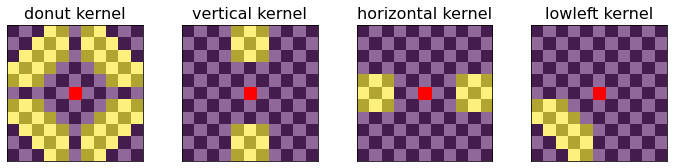

In [6]:
# function to draw kernels:
def draw_kernel(kernel, axis, cmap='viridis'):
    # kernel:
    imk = axis.imshow(
        kernel[::-1,::-1],  # flip it, as in convolution
        alpha=0.85,
        cmap=cmap,
        interpolation='none'
    )
    # draw a square around the target pixel:
    x0 = kernel.shape[0] // 2 - 0.5
    y0 = kernel.shape[1] // 2 - 0.5
    rect = patches.Rectangle((x0, y0), 1, 1, lw=1, ec='r', fc='r')
    axis.add_patch(rect)
    # clean axis:
    axis.tick_params(**clean_axis_kwargs)
    axis.set_title("{} kernel".format(ktype),fontsize=16)
    # add a checkerboard to highlight pixels:
    checkerboard = np.add.outer(range(kernel.shape[0]),
                                range(kernel.shape[1])) % 2
    # show it:
    axis.imshow(checkerboard,
            cmap='gray',
            interpolation='none',
            alpha=0.3)
    return imk

# create a grid of coordinates from -5 to 5, to define round kernels
# see https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html for details
half = 5  # half width of the kernel
x, y = np.meshgrid(
    np.linspace(-half, half, 2*half + 1),
    np.linspace(-half, half, 2*half + 1),
)
# now define a donut-like mask as pixels between 2 radii: sqrt(7) and sqrt(30):
mask = (x**2+y**2 > 7) & (x**2+y**2 <= 30)
mask[:,half] = 0
mask[half,:] = 0

# lowleft mask - zero out neccessary parts
mask_ll = mask.copy()
mask_ll[:,:half] = 0
mask_ll[half:,:] = 0

# will be borrowing some of the recommended kernels: horizontal and vertical
recommended_kernels = cooltools.api.dotfinder.recommend_kernels(binsize)
# new kernels with more round donut and lowleft masks:
kernels_round = {'donut': mask,
 'vertical': recommended_kernels["vertical"].copy(),
 'horizontal': recommended_kernels["horizontal"].copy(),
 'lowleft': mask_ll}

# plot rounded kernels
fig, axs = plt.subplots(ncols=4, figsize=(12,2.5))
for ax, (ktype, kernel) in zip(axs, kernels_round.items()):
    imk = draw_kernel(kernel, ax)

#### call dots using redefined kernels

In [7]:
dots_round_df_all = cooltools.dots(
    clr,
    expected=expected,
    view_df=hg38_arms,
    kernels=kernels_round, # provide custom kernels
    max_loci_separation=10_000_000,
    clustering_radius=20_000,
    nproc=4,
)

/data/old_desktop/src/cooltools/cooltools/api/dotfinder.py:1565: UserWarning: Compatibility checks for 'kernels' are not fully implemented yet, use at your own risk
  warnings.warn(
INFO:root: matrix 9314X9314 to be split into 361 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 14907X14907 to be split into 900 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 2472X2472 to be split into 25 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 5855X5855 to be split into 144 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root:convolving 186 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 4 workers to tackle 186 tiles
INFO:root:Done building histograms in 32.121 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:root:con

### Define regions of interest for the figure and extract all of the features for that region
 - region
 - heatmap of Observed for the region
 - heatmap of OOE for the region
 - dots from the region
 - pileup of Observed for those dots
 - pileup of OOE for the dots

In [8]:
# define a region to look into as an example
start = 34_100_000
end = start + 1_200_000
region = ('chr17', start, end)

# get the name of the arm this region is on (for ToEplitz expected mostly)
arm_name = bioframe.select(hg38_arms,region)["name"].iat[0]

# compute heatmap for the region
region_matrix = clr.matrix(balance=True).fetch(region)
for diag in [-1,0,1]:
    region_matrix = fill_diag(region_matrix, np.nan, i=diag)
    
# region OOE matrix
region_exp = cooltools.numutils.LazyToeplitz(
    expected.loc[expected["region1"]==arm_name,"balanced.avg"].to_numpy()
)
h,w = region_matrix.shape
region_OOE = region_matrix/region_exp[:h,:w]

# select dots from the region only
# just 10 dots really - for the region in mind ...
dots_in_region = bioframe.select(
    bioframe.select(dots_round_df_all, region, cols=("chrom1","start1","end1")),
    region,
    cols=("chrom2","start2","end2"),
)

# OOE and Observed pileups for the dots in the region
flank = clr.binsize * (kernels_round["donut"].shape[0]//2 + 2)
# # could use dots of certain idstnace range instead ....
# dots_round_df_all.query('start2-start1>160_000 and start2-start1<1_000_000'),
stack = cooltools.pileup(clr, 
                         dots_in_region,
                         view_df=hg38_arms,
                         # no expected triggers pileup of observed - APA
                         flank=flank) 
mtx = np.nanmean(stack, axis=2)

# OOE ...
stack_ooe = cooltools.pileup(clr, 
                         dots_in_region,
                         view_df=hg38_arms,
                         expected_df=expected, 
                         flank=flank) 
mtx_ooe = np.nanmean(stack_ooe, axis=2)

### Define and test several plotting functions...
 - one for plotting squares around "dots" on a rectangular heatmap
 - one for plotting 45 degree angle tilted heatmap (taken from insulation notebook)
 - one for plotting 45 degree angle tilted rectangles around dots on a tilted heatmap

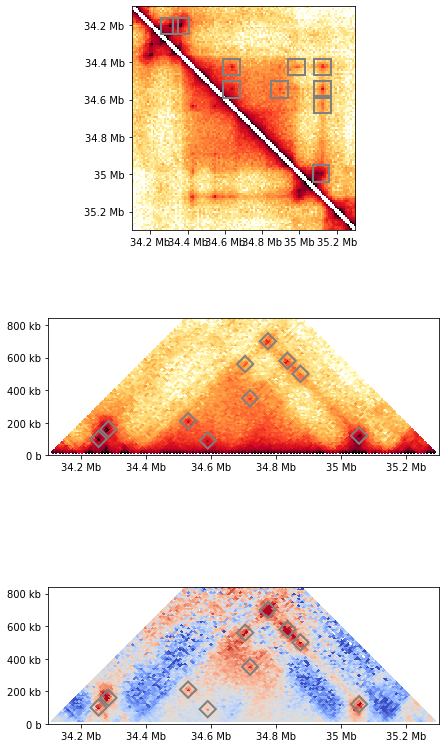

In [9]:
def plain_rectangles_around_dots(
    dots_df, 
    flank_size=50_000,
    lw=2,
    ec="darkgreen",
    fc="none",
    alpha=0.4
):
    """
    yield a series of rectangles around called dots in a given region
    """   
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc, alpha=alpha)
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for i, s1, s2, e1, e2 in dots_df[["start1", "start2", "end1", "end2"]].itertuples():
        x = s2 - flank_size
        y = s1 - flank_size
        dx = 2*flank_size + (e2-s2)
        dy = 2*flank_size + (e1-s1)
        yield patches.Rectangle( (x, y), dx, dy, **rectangle_kwargs )

# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    """heatmap tilted at 45 degree angle ..."""
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

def plain_rectangles45_around_dots(
    dots_df,
    window_size=50_000,
    lw=2,
    ec="darkgreen",
    fc="none",
    alpha=0.4,
):
    """
    yield a series of rectangles around called dots
    works on 45-deg tilted heatmaps with 0.5 aspect ratio
    """
    path_kwargs = dict(lw=lw, ec=ec, fc=fc, alpha=alpha)
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for i, s1, s2, e1, e2 in dots_df[["start1", "start2", "end1", "end2"]].itertuples():
        # somewhat empirically derived coordinates ...
        y = abs(s1-s2)  # genomic separation
        x = s2 - .5*y + (e2-s2)/2
        delta = window_size + (e2-s2)
        # draw a path around a dot (assuming 0.5 aspect ratio)...
        verts = [
           (x - .5*delta, y),  # left (start)
           (x,            y + delta),  # top
           (x + .5*delta, y),  # right
           (x,            y - delta),  # bottom
           (x - .5*delta, y),  # left (start)
        ]
        codes = [
            Path.MOVETO,
            Path.LINETO,
            Path.LINETO,
            Path.LINETO,
            Path.CLOSEPOLY,
        ]
        path = Path(verts, codes)
        yield patches.PathPatch(path, **path_kwargs)


f, axd = plt.subplot_mosaic([["up"],["bot"],["oe"]], figsize=(7,14))

# test regular heatmap
im = axd["up"].matshow(region_matrix, extent=[start, end, end, start], **obs_kwargs)
format_ticks(axd["up"], rotate=False)
# plt.colorbar(im, ax=axd["up"], **colorbar_kwargs)     
# draw rectangular "boxes" around pixels called as dots in the "region":
for rect in plain_rectangles_around_dots(dots_in_region, flank_size=40_000, **rect_kwargs):
    axd["up"].add_patch(rect)

# test draw 45-tilted Obs heatmap
im = pcolormesh_45deg(
    axd["bot"],
    region_matrix,
    start=region[1],
    resolution=binsize,
    **obs_kwargs,
)
format_ticks(axd["bot"], rotate=False)
axd["bot"].set_aspect(0.5)
axd["bot"].set_ylim(0, np.diff(region[1:])[0]*0.7)
# draw rectangular "boxes" around pixels called as dots in the "region":
for rect in plain_rectangles45_around_dots(dots_in_region, window_size=40_000, **rect_kwargs):
    axd["bot"].add_patch(rect)

im = pcolormesh_45deg(
    axd["oe"],
    region_OOE,
    start=region[1],
    resolution=binsize,
    **ooe_kwargs
)
format_ticks(axd["oe"], rotate=False)
axd["oe"].set_aspect(0.5)
axd["oe"].set_ylim(0, np.diff(region[1:])[0]*0.7)
# draw rectangular "boxes" around pixels called as dots in the "region":
for rect in plain_rectangles45_around_dots(dots_in_region, window_size=40_000, **rect_kwargs):
    axd["oe"].add_patch(rect)

## Figure "Dots"
a piece of a heatmap with the called dots along with the demonstration of kernel-masks applied to an individual snippet

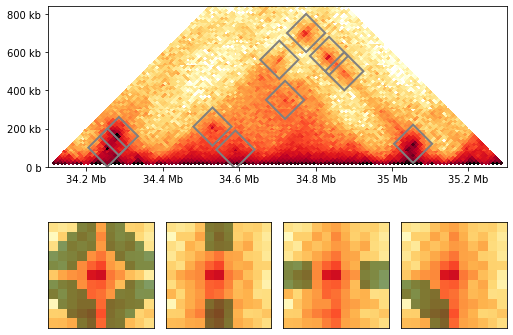

In [10]:
# function to draw kernels:
def draw_kernel_mask(kernel, ax, offset=0, cmap='viridis', alpha=0.4):
    w,h = kernel.shape
    im = np.empty((w+2*offset, h+2*offset))
    im.fill(np.nan)
    _from = offset
    _to = -offset if offset else None
    im[_from:_to, _from:_to] = kernel[::-1,::-1]
    return ax.imshow(
        im,  # flip it, as in convolution
        alpha=alpha,
        cmap=cmap,
        interpolation='none'
    )

fig, axd = plt.subplot_mosaic([['upper', 'upper', 'upper', 'upper'],
                               ["donut","vertical","horizontal","lowleft"]],
                              figsize=(7, 5), constrained_layout=True)
# plot heatmap at 45 deg
im = pcolormesh_45deg(
    axd["upper"],
    region_matrix,
    start=region[1],
    resolution=binsize,
    **obs_kwargs,
)
format_ticks(axd["upper"], rotate=False)
axd["upper"].set_aspect(0.5)
axd["upper"].set_ylim(0, np.diff(region[1:])[0]*0.7)
# draw rectangular "boxes" around pixels called as dots in the "region":
for rect in plain_rectangles45_around_dots(dots_in_region, window_size=90_000, **rect_kwargs):
    axd["upper"].add_patch(rect)
    
_matrix = stack[:,:, 2]
# see viz.ipynb for details of heatmap visualization
for ktype, kernel in kernels_round.items():
    xxx = kernel.copy().astype(float)
    xxx[kernel==0] = np.nan
    # plot snippet and a kernel-mask on top of it
    im = axd[ktype].matshow( _matrix[2:-2,2:-2], **obs_snippet_kwargs)
    imk = draw_kernel_mask(xxx, axd[ktype], offset=0, cmap="Greens_r", alpha=0.5)
    # clean axis:
    axd[ktype].tick_params(**clean_axis_kwargs)

## Figure pileups - to be continued

Text(0.5, 0.92, 'stack of Observed snippets')

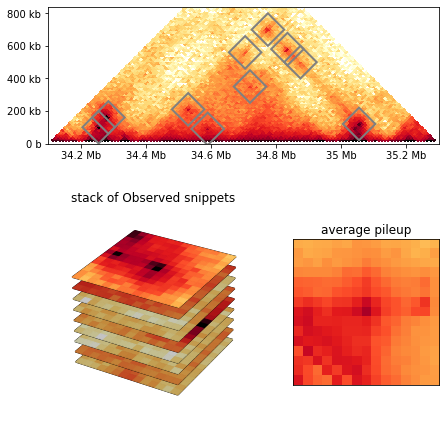

In [11]:
# create a 21 x 21 vertex mesh
dimens, *_ = stack.shape
X, Y = np.meshgrid(np.linspace(0,1,dimens), np.linspace(0,1,dimens))
# create vertices for a rotated mesh (3D rotation matrix)
Z =  np.zeros_like(X)
# create the figure
fig, axs = plt.subplot_mosaic(
    [["up","up"],["stack","pileup"]],
    figsize=(7,8),
    gridspec_kw={"width_ratios":[1,0.7], "height_ratios":[1,1.2]}
)

# heatmap Observed
im = pcolormesh_45deg(
    axs["up"],
    region_matrix,
    start=region[1],
    resolution=binsize,
    **obs_kwargs,
)
format_ticks(axs["up"], rotate=False)
axs["up"].set_aspect(0.5)
axs["up"].set_ylim(0, np.diff(region[1:])[0]*0.7)
# draw rectangular "boxes" around pixels called as dots in the "region":
for rect in plain_rectangles45_around_dots(dots_in_region, window_size=90_000, **rect_kwargs):
    axs["up"].add_patch(rect)

# average pileup
im = axs["pileup"].imshow(
    mtx,
    aspect="equal",
    interpolation="none",
    **obs_kwargs,
)
axs["pileup"].tick_params(**clean_axis_kwargs)
axs["pileup"].set_title("average pileup")

# https://stackoverflow.com/questions/35209489/can-i-turn-an-existing-ax-object-into-a-3d-projection
# show the 3D rotated projection
axs["stack"].remove()
axs["stack"] = fig.add_subplot(2, 2, 3, projection='3d')
num_to_show = 8
for i, _matrix in enumerate( np.rollaxis(stack, 2) ):
    if i > num_to_show:
        break        
    is_top_element = i!=num_to_show
    # get the heatmap for the region
    axs["stack"].plot_wireframe(X, Y, Z+i/num_to_show, rstride=1, cstride=1, color="black")
    axs["stack"].plot_surface(
        X,
        Y,
        Z+i/num_to_show,
        rstride=1,
        cstride=1,
        facecolors=fall_hm(obs_norm(_matrix)),
        shade=is_top_element,
    )
axs["stack"].set_axis_off()
axs["stack"].set_title("stack of Observed snippets")

### same - but OOE...

Text(0.5, 0.92, 'stack of OOE snippets')

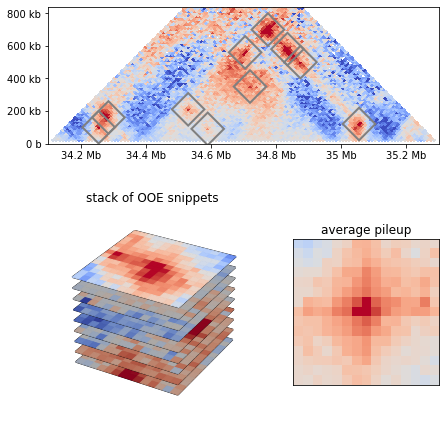

In [12]:
# create a 21 x 21 vertex mesh
dimens, *_ = stack.shape
X, Y = np.meshgrid(np.linspace(0,1,dimens), np.linspace(0,1,dimens))
# create vertices for a rotated mesh (3D rotation matrix)
Z =  np.zeros_like(X)
# create the figure
fig, axs = plt.subplot_mosaic(
    [["up","up"],["stack","pileup"]],
    figsize=(7,8),
    gridspec_kw={"width_ratios":[1,0.7], "height_ratios":[1,1.2]}
)

# heatmap OOE
im = pcolormesh_45deg(
    axs["up"],
    region_OOE,
    start=region[1],
    resolution=binsize,
    **ooe_kwargs,
)
format_ticks(axs["up"], rotate=False)
axs["up"].set_aspect(0.5)
axs["up"].set_ylim(0, np.diff(region[1:])[0]*0.7)
# draw rectangular "boxes" around pixels called as dots in the "region":
for rect in plain_rectangles45_around_dots(dots_in_region, window_size=90_000, **rect_kwargs):
    axs["up"].add_patch(rect)

# average pileup
im = axs["pileup"].imshow(
    mtx_ooe,
    aspect="equal",
    interpolation="none",
    **ooe_kwargs,
)
axs["pileup"].tick_params(**clean_axis_kwargs)
axs["pileup"].set_title("average pileup")

# show the 3D rotated projection
axs["stack"].remove()
axs["stack"] = fig.add_subplot(2,2,3,projection='3d')
num_to_show = 8
for i, _matrix in enumerate( np.rollaxis(stack_ooe, 2) ):
    if i > num_to_show:
        break        
    is_top_element = i!=num_to_show
    # get the heatmap for the region
    axs["stack"].plot_wireframe(X, Y, Z+i/num_to_show, rstride=1, cstride=1,color="black")
    axs["stack"].plot_surface(
        X,
        Y,
        Z+i/num_to_show,
        rstride=1,
        cstride=1,
        facecolors=cm.get_cmap("coolwarm")(ooe_norm(_matrix)),
        shade=is_top_element,
    )
axs["stack"].set_axis_off()
axs["stack"].set_title("stack of OOE snippets")